In [24]:
# Manipulação de sistema para ajustar paths de importação
import sys
import os

# Adiciona o diretório raiz do projeto ao sys.path para conseguir importar configs
sys.path.append(os.path.abspath('../..'))

#chamando a função do módulo configs.py que mapeia as pastas no ambiente
import configs as cf
cf.mapeia_pastas()

# Importa funções auxiliares personalizadas
import functions as fc

In [25]:
# Cria conexão com o banco de dados DuckDB
con = cf.criar_conexao_db()

In [26]:
# Exibe as tabelas existentes no banco de dados
con.execute("SHOW TABLES").df()

,name
0,tbl_advogados_brasil_2024
1,tbl_contadores_brasil_2024
2,tbl_engenheiros_brasil_2024
3,tbl_estados_brasil
4,tbl_psicologos_brasil_2024


In [5]:
# Dicionário com os nomes das tabelas do banco, organizados por profissão e estados
tabelas = {
    "advogados": "tbl_advogados_brasil_2024",
    "contadores": "tbl_contadores_brasil_2024",
    "engenheiros": "tbl_engenheiros_brasil_2024",
    "psicologos": "tbl_psicologos_brasil_2024",
    "estados": "tbl_estados_brasil"
}

# Cria um dicionário de DataFrames contendo os dados de cada tabela
tabela = {nome: con.execute(f"SELECT * FROM {tabela}").df() for nome, tabela in tabelas.items()}

In [6]:
# Cria um DataFrame unificando todas as tabelas de profissões
# Adiciona uma coluna 'profissao' para identificar de qual tabela veio cada registro
df_profissoes = con.execute("""
    SELECT *, 'advogado' AS profissao
    FROM tbl_advogados_brasil_2024

    UNION ALL

    SELECT *, 'contador' AS profissao
    FROM tbl_contadores_brasil_2024

    UNION ALL

    SELECT *, 'engenheiro' AS profissao
    FROM tbl_engenheiros_brasil_2024

    UNION ALL

    SELECT *, 'psicologo' AS profissao
    FROM tbl_psicologos_brasil_2024
""").df()
df_profissoes

,estado,feminino,masculino,profissao
0,AC,1898,2078,advogado
1,AL,7376,7847,advogado
2,AM,8181,7544,advogado
3,AP,2124,2049,advogado
4,BA,33281,28654,advogado
...,...,...,...,...
103,Roraima,971,167,psicologo
104,Santa Catarina,17963,2739,psicologo
105,São Paulo,132077,22613,psicologo
106,Sergipe,3372,723,psicologo


In [7]:
df_profissoes[df_profissoes['profissao'] == 'advogado'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,27508.518519,25522.851852
std,39997.618600,36525.059606
min,1473.000000,1398.000000
25%,7741.000000,7695.500000
50%,13516.000000,12059.000000
75%,27792.500000,25293.500000
max,197236.000000,181116.000000


In [8]:
df_profissoes[df_profissoes['profissao'] == 'contador'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,7631.000000,6777.518519
std,11128.348709,9851.721413
min,501.000000,512.000000
25%,2207.000000,1976.000000
50%,4174.000000,4037.000000
75%,7952.000000,6521.000000
max,56528.000000,49302.000000


In [9]:
df_profissoes[df_profissoes['profissao'] == 'engenheiro'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,8695.222222,34465.666667
std,11525.265271,56973.482517
min,391.000000,1119.000000
25%,2029.000000,7572.000000
50%,4602.000000,17778.000000
75%,10007.500000,33231.500000
max,53124.000000,281812.000000


In [10]:
df_profissoes[df_profissoes['profissao'] == 'psicologo'].describe()

,feminino,masculino
count,27.000000,27.000000
mean,16698.592593,2884.222222
std,26513.606301,4540.061041
min,971.000000,167.000000
25%,4584.000000,756.000000
50%,6371.000000,1206.000000
75%,17526.500000,2834.500000
max,132077.000000,22613.000000


In [11]:
# Junta as tabelas de profissionais com a de estados
# Faz LEFT JOIN para cada profissão, trazendo os totais de masculino e feminino por estado
df_estados_profissoes = con.execute("""
    SELECT
        a.id,
        a.nome_estado,
        b.M_advogados,
        b.F_advogados,
        c.M_contadores,
        c.F_contadores,
        d.M_engenheiros,
        d.F_engenheiros,
        e.M_psicologos,
        e.F_psicologos
    
    FROM tbl_estados_brasil AS a 
    
    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_advogados,
            feminino AS F_advogados
        FROM tbl_advogados_brasil_2024        
    ) AS b ON UPPER(a.uf) = b.estado

    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_contadores,
            feminino AS F_contadores
        FROM tbl_contadores_brasil_2024
    ) AS c ON UPPER(a.uf) = c.estado

    LEFT JOIN(
        SELECT 
            UPPER(REPLACE(estado, 'CREA-', '')) AS estado,
            masculino AS M_engenheiros,
            feminino AS F_engenheiros
        FROM tbl_engenheiros_brasil_2024
    ) AS d ON UPPER(a.uf) = d.estado

    LEFT JOIN(
        SELECT 
            UPPER(estado) AS estado,
            masculino AS M_psicologos,
            feminino AS F_psicologos
        FROM tbl_psicologos_brasil_2024
    ) AS e ON UPPER(a.nome_estado) = e.estado
""").df()

In [12]:
# Registra o DataFrame resultante como uma tabela temporária no DuckDB
con.register("df_estados_profissoes", df_estados_profissoes)

In [13]:
df_estados_profissoes

,id,nome_estado,M_advogados,F_advogados,M_contadores,F_contadores,M_engenheiros,F_engenheiros,M_psicologos,F_psicologos
0,1,Acre,2078,1898,512,539,1892,710,236,1181
1,2,Alagoas,7847,7376,1433,1832,7159,1677,991,5399
2,4,Amazonas,7544,8181,3106,2532,11833,4236,996,5163
3,5,Amapá,2049,2124,660,743,1278,391,261,1201
4,6,Bahia,28654,33281,7314,9497,39436,12202,3559,21113
5,7,Ceará,20292,19541,4375,5587,19166,4673,2508,12387
6,8,Distrito Federal,25358,26508,4512,6407,18081,4602,2407,13246
7,9,Espírito Santo,13009,14451,4174,4174,17778,6004,1499,7601
8,10,Goiás,25229,28562,4137,6276,28991,8487,1966,13638
9,11,Maranhão,12020,12026,2475,3425,12044,3821,1028,5475


In [14]:
# Executa função que conta a quantidade total de profissionais para cada profissão
advogados = fc.contar_profissionais(con,'M', 'F', 'advogados')
contadores = fc.contar_profissionais(con,'M', 'F', 'contadores')
engenheiros = fc.contar_profissionais(con,'M', 'F', 'engenheiros')
psicologos = fc.contar_profissionais(con,'M', 'F', 'psicologos')

In [15]:
# Define lista de profissões e paleta de cores para os gráficos
profissoes = ['advogados', 'contadores', 'engenheiros', 'psicologos']
cores = ['#bdc3c7', '#d7ccc8', '#616161', '#839192']

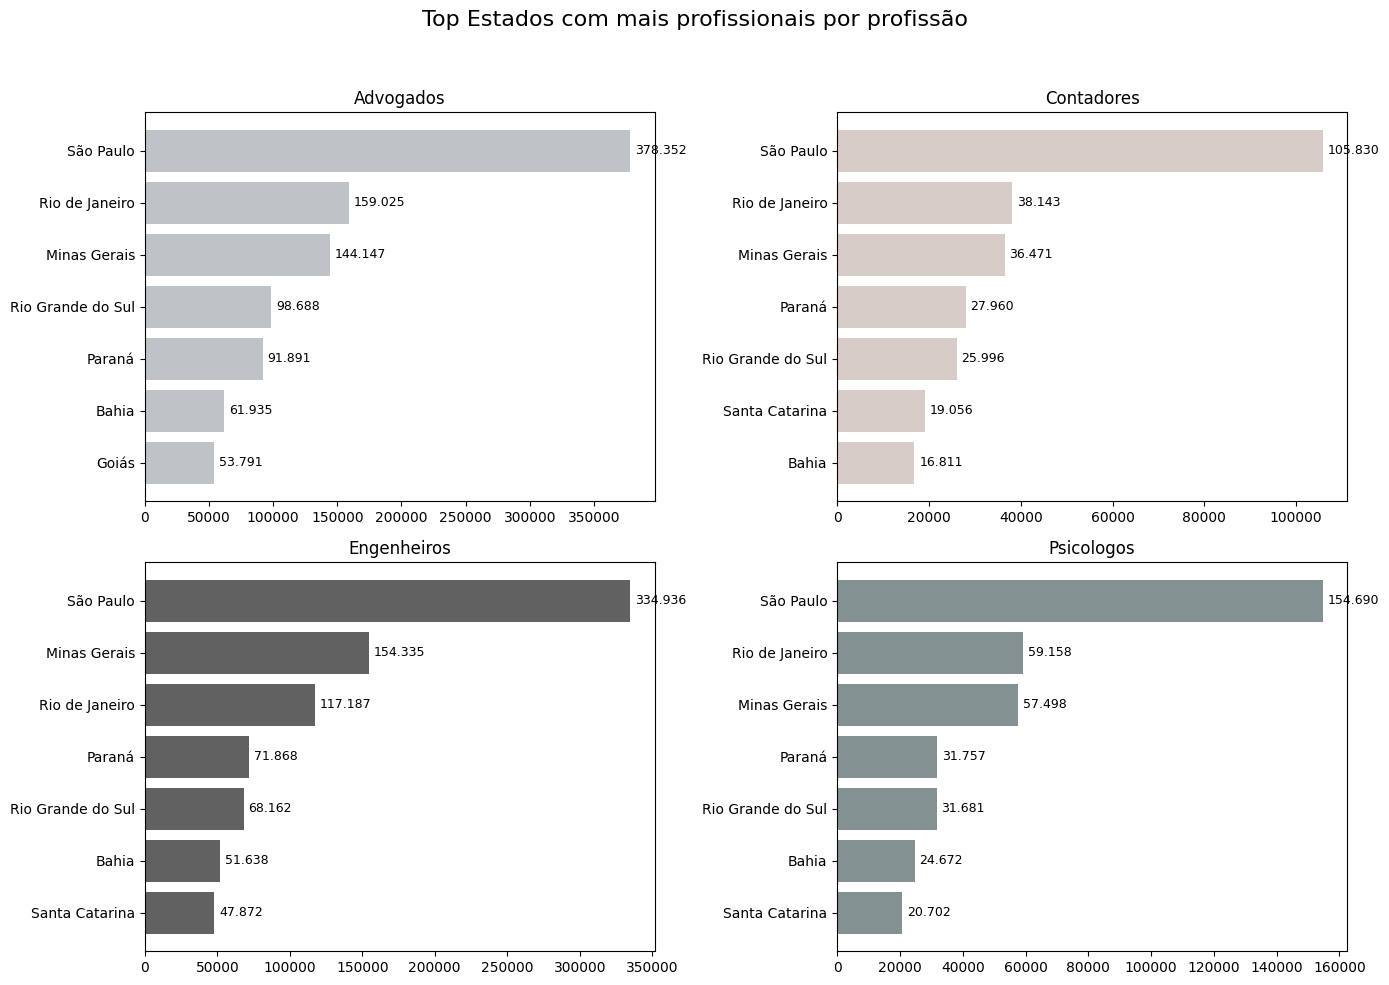

In [16]:
# Gera gráfico com os estados com maior número de profissionais para cada profissão
grafico_maiores_estados = fc.plotar_maiores_estados_profissoes(con, profissoes, cores)

In [17]:
# Cria DataFrames com os estados que têm mais profissionais do gênero masculino
maiores_estados_masculino = fc.distribuir_profissao_por_genero(con, 'M', 'total_masculino')
maiores_estados_masculino

,nome_estado,advogados,contadores,engenheiros,psicologos,total_masculino
0,São Paulo,181116.0,49302.0,281812.0,22613.0,534843.0
1,Minas Gerais,69942.0,18568.0,121679.0,9033.0,219222.0
2,Rio de Janeiro,74423.0,17855.0,93569.0,8476.0,194323.0
3,Paraná,44869.0,12027.0,58273.0,4695.0,119864.0
4,Rio Grande do Sul,47028.0,13618.0,54101.0,4001.0,118748.0
5,Bahia,28654.0,7314.0,39436.0,3559.0,78963.0
6,Santa Catarina,25110.0,9328.0,37472.0,2739.0,74649.0


In [18]:
# Cria DataFrames com os estados que têm mais profissionais do gênero feminino
maiores_estados_feminino = fc.distribuir_profissao_por_genero(con, 'F', 'total_feminino')
maiores_estados_feminino

,nome_estado,advogadas,contadoras,engenheiras,psicologas,total_feminino
0,São Paulo,197236.0,56528.0,53124.0,132077.0,438965.0
1,Rio de Janeiro,84602.0,20288.0,23618.0,50682.0,179190.0
2,Minas Gerais,74205.0,17903.0,32656.0,48465.0,173229.0
3,Rio Grande do Sul,51660.0,12378.0,14061.0,27680.0,105779.0
4,Paraná,47022.0,15933.0,13595.0,27062.0,103612.0
5,Bahia,33281.0,9497.0,12202.0,21113.0,76093.0
6,Santa Catarina,27023.0,9728.0,10400.0,17963.0,65114.0


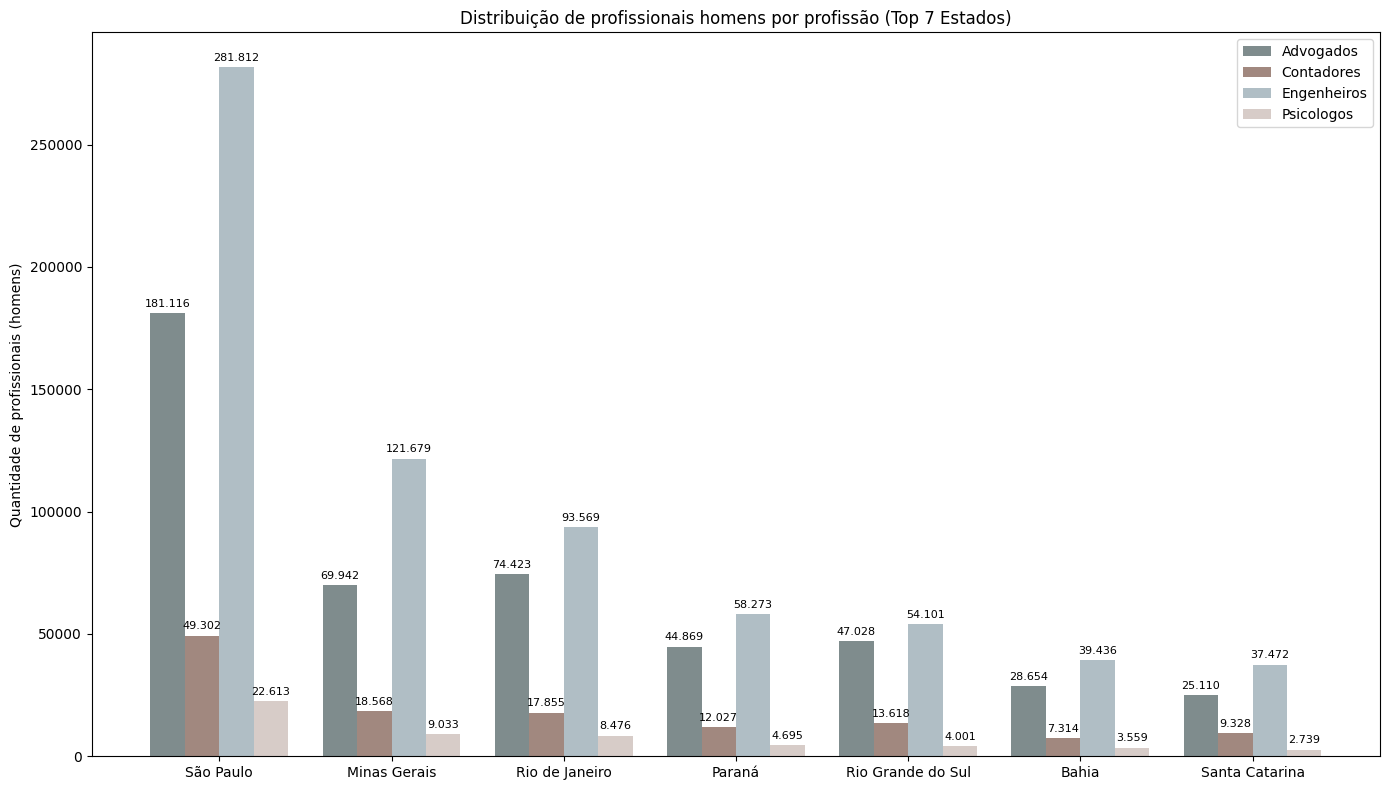

In [19]:
# Gera gráfico de distribuição de profissionais homens por estado e profissão
grafico_distribuicao_homens = fc.plotar_distribuicao_genero(
    df = maiores_estados_masculino,
    profissoes = ['advogados', 'contadores', 'engenheiros', 'psicologos'],
    titulo = 'Distribuição de profissionais homens por profissão (Top 7 Estados)',
    cor_legenda = ['#7f8c8d', '#a1887f', '#b0bec5', '#d7ccc8'],
    genero_label = 'homens'
)

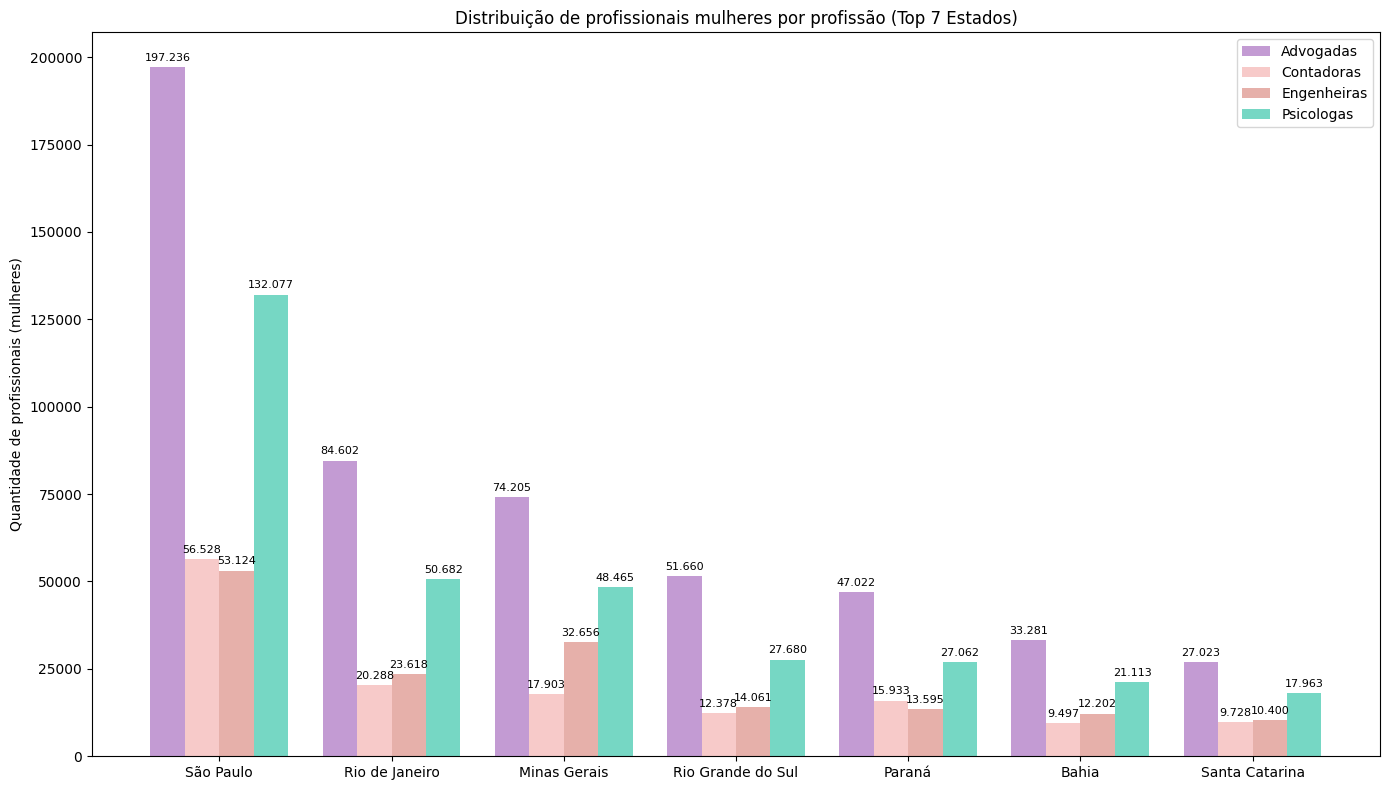

In [20]:
# Gera gráfico de distribuição de profissionais mulheres por estado e profissão
grafico_distribuicao_mulheres = fc.plotar_distribuicao_genero(
    df = maiores_estados_feminino,
    profissoes = ['advogadas', 'contadoras', 'engenheiras', 'psicologas'],
    titulo = 'Distribuição de profissionais mulheres por profissão (Top 7 Estados)',
    cor_legenda = ['#c39bd3', '#f7cac9', '#e6b0aa', '#76d7c4'],
    genero_label = 'mulheres'
)

In [21]:
# Cria um dicionário com os DataFrames de resultados e gráficos gerados
dataframes_result = {
    "advogados": advogados,
    "contadores": contadores,
    "engenheiros": engenheiros,
    "psicologos": psicologos,
    "maiores_estados_masculino": maiores_estados_masculino,
    "maiores_estados_feminino": maiores_estados_feminino
}

In [22]:
# Salva os dados de resultados em arquivos JSON
fc.salvar_json(dataframes_result)

Arquivo advogados.json salvo em c:\Users\Gabriel\Desktop\distribuicao_profissao\distribuicao-de-profissoes\analise_de_dados\app\../result\advogados.json
Arquivo contadores.json salvo em c:\Users\Gabriel\Desktop\distribuicao_profissao\distribuicao-de-profissoes\analise_de_dados\app\../result\contadores.json
Arquivo engenheiros.json salvo em c:\Users\Gabriel\Desktop\distribuicao_profissao\distribuicao-de-profissoes\analise_de_dados\app\../result\engenheiros.json
Arquivo psicologos.json salvo em c:\Users\Gabriel\Desktop\distribuicao_profissao\distribuicao-de-profissoes\analise_de_dados\app\../result\psicologos.json
Arquivo maiores_estados_masculino.json salvo em c:\Users\Gabriel\Desktop\distribuicao_profissao\distribuicao-de-profissoes\analise_de_dados\app\../result\maiores_estados_masculino.json
Arquivo maiores_estados_feminino.json salvo em c:\Users\Gabriel\Desktop\distribuicao_profissao\distribuicao-de-profissoes\analise_de_dados\app\../result\maiores_estados_feminino.json


In [23]:
con.close()